In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras

import smfret.fit as fit

from smfret.tf_layers import Attention
from smfret.tf_layers import Conv
from smfret.tf_layers import Summary
from smfret.tf_layers import PrependTaskToken
from smfret.tf_layers import Embedding
from smfret.tf_layers import PositionEmbedding

import smfret.evaluation as evaluation

from smfret.trace_simulator import Simulator
from smfret.trace_simulator import ParameterGenerator
from smfret.trace_simulator import SimulatedTraceSet

from smfret.multi_task_learning import FRETStateTraceSet
from smfret.multi_task_learning import TwoStateQuickDynamicTraceSet
from smfret.multi_task_learning import SavedTraceSet
from smfret.dataset import MatlabTraceSet
from smfret.dataset import FRETTraceSet


from sklearn.manifold import TSNE
from sklearn import metrics

from sciplotlib import style as spstyle
from colorama import Fore, Back, Style


In [10]:
trace_set = SavedTraceSet(file='saved_dataset/test/FRETSTATE_3STATE.npz', size=2500)

In [3]:
trace_set += SavedTraceSet(file='saved_dataset/test/FRETSTATE_4STATE.npz', size=2500)

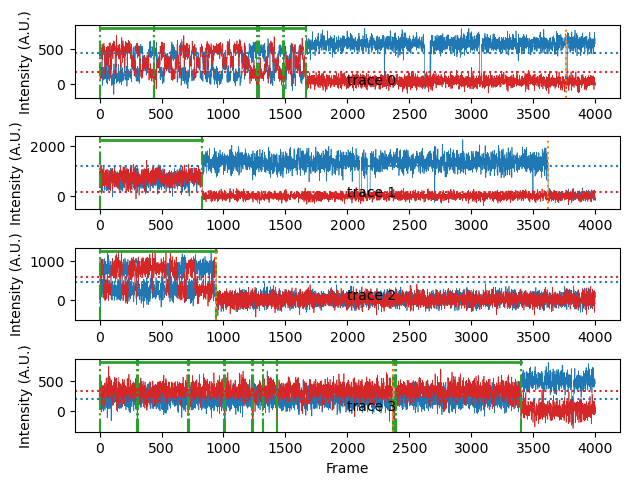

In [11]:
trace_set.plot_traces(n_start=0, n_traces=4)

In [12]:
ref_set = trace_set

In [13]:
def use_posterior(prob, max_marginal_prob=0.05):
    marginal_prob = np.mean(prob, axis=-2)
    marginal_prob[marginal_prob >= max_marginal_prob] = max_marginal_prob
    post_prob = np.einsum('itk,ik->itk', prob, marginal_prob)
    return post_prob

In [14]:
# linetime measurement

def lifetime(label):
    """Finds the lifetime according to the labeled states."""
    l = 0
    label = np.array(label)
    for i in range(len(label) - 1, 0, -1):
        if label[i] > 0:
            return i
    return 0

In [15]:
# lifetime MAE

model = keras.models.load_model(f'saved_models/lstm-model-20240423-203825/FRETSTATE.h5', compile=False, custom_objects={'PositionEmbedding': PositionEmbedding})
# ideal_fret = tf.cast(tf.argmax(model.predict(ref_set.to_tensor()), axis=-1), tf.float32)
ideal_fret = tf.cast(tf.argmax(use_posterior(tf.math.softmax(model.predict(ref_set.to_tensor()), axis=-1)), axis=-1), tf.float32)
error = []

for i in range(len(ref_set.traces)):
    error.append(ref_set.label[i, ...] - ideal_fret[i, ...])

print('MAE=', FRETStateTraceSet.fret_states_resolution * np.mean(np.abs(np.array(error))))

79/79 [==============================] - 10s 96ms/step
MAE= 0.006949315220117569


In [17]:
model = keras.models.load_model(f'saved_models/lstm-model-20240423-203825/FRETSTATE_3STATE.h5', compile=False, custom_objects={'PositionEmbedding': PositionEmbedding})
# ideal_fret = tf.cast(tf.argmax(model.predict(ref_set.to_tensor()), axis=-1), tf.float32)
ideal_fret = tf.cast(tf.argmax(use_posterior(tf.math.softmax(model.predict(ref_set.to_tensor()), axis=-1)), axis=-1), tf.float32)
error = []

for i in range(len(ref_set.traces)):
    error.append(ref_set.label[i, ...] - ideal_fret[i, ...])

print('MAE=', FRETStateTraceSet.fret_states_resolution * np.mean(np.abs(np.array(error))))

79/79 [==============================] - 10s 92ms/step
MAE= 0.006871459633111954


In [ ]:
model = keras.models.load_model(f'saved_models/lstm-model-20240423-203825/FRETSTATE_4STATE.h5', compile=False, custom_objects={'PositionEmbedding': PositionEmbedding})
# ideal_fret = tf.cast(tf.argmax(model.predict(ref_set.to_tensor()), axis=-1), tf.float32)
ideal_fret = tf.cast(tf.argmax(use_posterior(tf.math.softmax(model.predict(ref_set.to_tensor()), axis=-1)), axis=-1), tf.float32)
error = []

for i in range(len(ref_set.traces)):
    error.append(ref_set.label[i, ...] - ideal_fret[i, ...])

print('MAE=', FRETStateTraceSet.fret_states_resolution * np.mean(np.abs(np.array(error))))

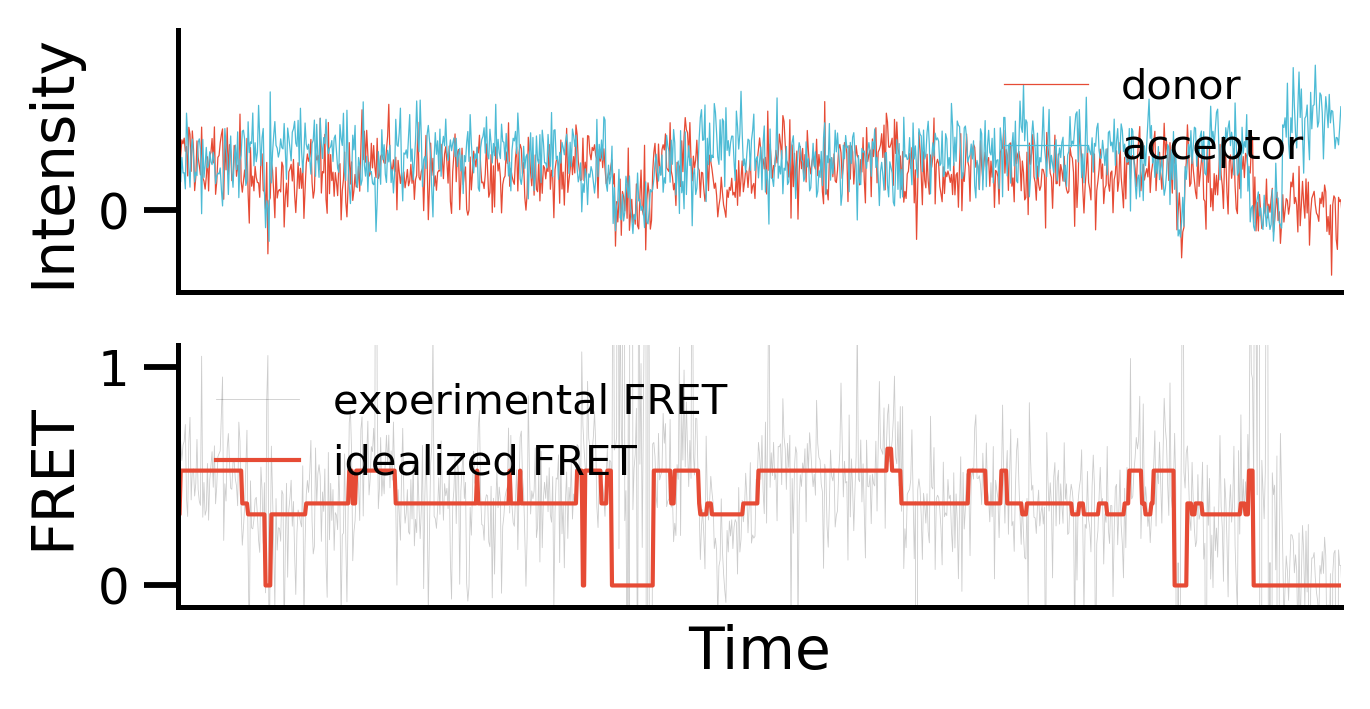

In [33]:
n = 28
with plt.style.context(spstyle.get_style('nature-reviews')):
    fig, axes = plt.subplots(2, 1, figsize=(5, 2.5))
    # print(correct_state_count[n])
    ax=axes[0]
    ax.plot(ref_set.traces[n].acceptor , linewidth=0.3, label='donor')
    ax.plot(ref_set.traces[n].donor , linewidth=0.3, label='acceptor')
    ax.set_xticks([])
    ax.set_yticks([0])
    ax.set_ylabel('Intensity')
    # ax.set_xlabel('Time', fontsize=6, verticalalignment='top')
    ax.set_xlim([0, 1000])
    ax.legend()
    
    ax=axes[1]
    ax.plot(ref_set.traces[n].fret, linewidth=0.2, color='k', alpha=0.2, label='experimental FRET')
    ax.plot(np.maximum(ideal_fret[n, ...] - 0.5, 0) * FRETStateTraceSet.fret_states_resolution, linewidth=1, label='idealized FRET')
    # ax.tick_params(which='major', width=1.0, length=3, labelsize=10)
    # ax.tick_params(which='minor', width=1.0, length=2, labelsize=10,
               # labelcolor='0.25')
    plt.xticks([])
    plt.yticks([0, 1])
    ax.set_ylabel('FRET')
    ax.set_xlabel('Time')
    ax.set_xlim([0, 1000])
    plt.ylim(-0.1, 1.1)
    
    # ax.spines["top"].set_visible(True)
    # ax.spines["right"].set_visible(True)

    ax.legend()

    plt.savefig(f'figures/trace_example_3_states{n}.svg', transparent=True)
    plt.savefig(f'figures/trace_example_3_states{n}.png', transparent=True)
    
    # ax.set_title("FRET States", fontsize=8, verticalalignment='center')
    # plt.savefig('figures/trace_with_fret.svg', transparent=True)
    # plt.savefig('figures/trace_with_fret.png', transparent=True)

In [ ]:
#### lifetime MAE

model = keras.models.load_model(f'saved_models/lstm-model-20240423-203825/FRETSTATE.h5', compile=False, custom_objects={'PositionEmbedding': PositionEmbedding})
# ideal_fret = tf.cast(tf.argmax(model.predict(ref_set.to_tensor()), axis=-1), tf.float32)
ideal_fret = tf.cast(tf.argmax(use_posterior(tf.math.softmax(model.predict(ref_set.to_tensor()), axis=-1)), axis=-1), tf.float32)

true_lifetime = []
predicted_lifetime = []
correct_state_count = []
high_fret_error = []
low_fret_error = []

for i in range(len(ref_set.traces)):
    true_lifetime.append(lifetime(ref_set.label[i, ...]))
    predicted_lifetime.append(lifetime(ideal_fret[i, ...]))
    correct_state_count.append(len(np.unique(ideal_fret[i, ...] // 2)) == 3)
    high_fret_error.append(np.max(ideal_fret[i, ...]) - np.max(ref_set.label[i, ...]))
    x, y = ideal_fret[i, ...], ref_set.label[i, ...]
    x, y = x[x>0], y[y>0]
    low_fret_error.append(np.min(x) - np.min(y))

print('MAE=', np.mean(np.abs(np.array(true_lifetime) - np.array(predicted_lifetime))))
print('State Count Accuracy =', np.mean(correct_state_count))
print('MAE High FRET=', FRETStateTraceSet.fret_states_resolution * np.mean(np.abs(high_fret_error)))
print('MAE Low FRET=', FRETStateTraceSet.fret_states_resolution * np.mean(np.abs(low_fret_error)))

In [ ]:
# Generate a dataset with:
# 1. K12 and K21
# 2. E1 and E2.



In [336]:
rng = np.random.default_rng()

def make_transition_prob_fn(transfer_matrix):
    counter = 0
    def transition_prob_fn():
        nonlocal counter
        k = transfer_matrix.flatten()[counter % transfer_matrix.size]
        counter += 1
        return k
    return transition_prob_fn

def make_fret_value_fn(E1, E2, E3):
    counter = 0
    def fret_value_fn():
        nonlocal counter
        counter += 1
        if counter % 3 == 1:
            return E1
        elif counter % 3 == 2:
            return E2
        else:
            return E3
    return fret_value_fn


transfer_matrix = np.array([
    [0, 0.03, 0.02],
    [0.02, 0, 0.02],
    [0.04, 0.015, 0],
])
# uses default trace_length = 2000 
params_gen_base = ParameterGenerator(
    num_states_fn=lambda: 3,
    snr_signal_fn=lambda: rng.uniform(5, 12),
    snr_background_fn=lambda: rng.uniform(5, 12),
    transition_prob_fn=make_transition_prob_fn(transfer_matrix),
    fret_states_fn=make_fret_value_fn(0.3, 0.6, 0.9),
    donor_lifetime_fn=lambda: rng.uniform(low=4000, high=4000),
    trace_length_fn=lambda: 4000,
)

In [359]:
test_set = FRETStateTraceSet(size=100, params_gen=params_gen_base)

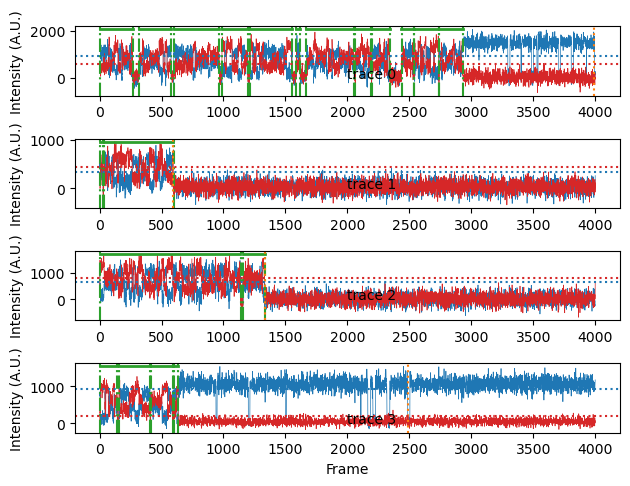

In [360]:
test_set.plot_traces(n_start=0, n_traces=4)

In [361]:
# lifetime MAE

model = keras.models.load_model(f'saved_models/lstm-model-20240423-203825/FRETSTATE.h5', compile=False, custom_objects={'PositionEmbedding': PositionEmbedding})
# ideal_fret = tf.cast(tf.argmax(model.predict(ref_set.to_tensor()), axis=-1), tf.float32)
ideal_fret = tf.cast(tf.argmax(use_posterior(tf.math.softmax(model.predict(test_set.to_tensor()), axis=-1)), axis=-1), tf.float32)

4/4 [==============================] - 7s 826ms/step


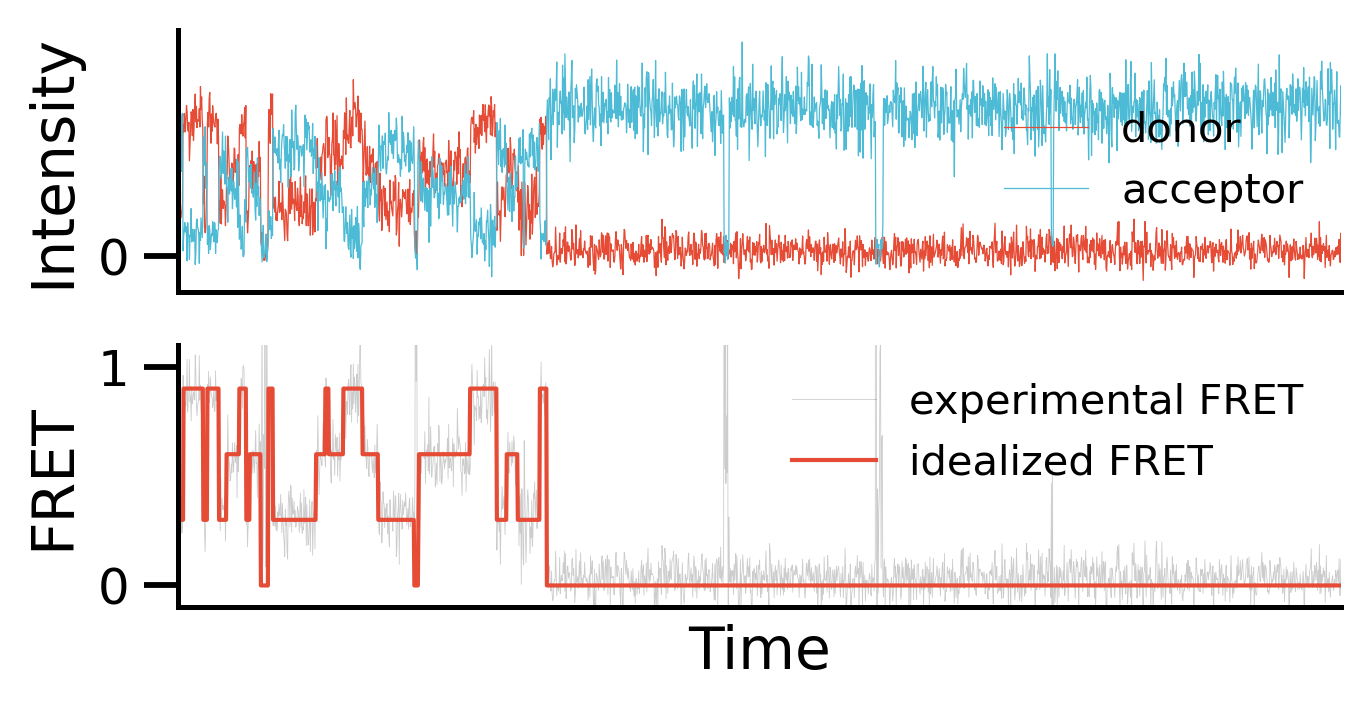

In [362]:
with plt.style.context(spstyle.get_style('nature-reviews')):
    fig, axes = plt.subplots(2, 1, figsize=(5, 2.5))
    n = 3
    # print(correct_state_count[n])
    ax=axes[0]
    ax.plot(test_set.traces[n].acceptor , linewidth=0.3, label='donor')
    ax.plot(test_set.traces[n].donor , linewidth=0.3, label='acceptor')
    ax.set_xticks([])
    ax.set_yticks([0])
    ax.set_ylabel('Intensity')
    # ax.set_xlabel('Time', fontsize=6, verticalalignment='top')
    ax.set_xlim([0, 2000])
    ax.legend()
    
    ax=axes[1]
    ax.plot(test_set.traces[n].fret, linewidth=0.2, color='k', alpha=0.2, label='experimental FRET')
    ax.plot(np.maximum(ideal_fret[n, ...] // 2, 0) * FRETStateTraceSet.fret_states_resolution * 2, linewidth=1, label='idealized FRET')
    # ax.tick_params(which='major', width=1.0, length=3, labelsize=10)
    # ax.tick_params(which='minor', width=1.0, length=2, labelsize=10,
               # labelcolor='0.25')
    plt.xticks([])
    plt.yticks([0, 1])
    ax.set_ylabel('FRET')
    ax.set_xlabel('Time')
    ax.set_xlim([0, 2000])
    plt.ylim(-0.1, 1.1)
    
    # ax.spines["top"].set_visible(True)
    # ax.spines["right"].set_visible(True)

    ax.legend()
    
    # ax.set_title("FRET States", fontsize=8, verticalalignment='center')
    plt.savefig('figures/trace_2_state_with_fret.svg', transparent=True)
    plt.savefig('figures/trace_2_state_with_fret.png', transparent=True)

In [363]:
def get_fret_value(trace, states, target_state):
    """Calcualtes the mean FRET value."""
    return list(trace.fret[states == target_state])

In [364]:
def reject_outliers(data, m = 2.):
    """Reject outliner datapoints."""
    data = np.array(data)
    d = np.abs(data - np.mean(data))
    mean = np.median(d)
    s = d / mean if mean else np.zeros(len(d))
    return data[s<m]

In [365]:
def get_cleaned_state(state, tau_min):
    cleaned_state = []
    persistent_frames = 0
    last_state = 0
    if tau_min == 1:
        return np.array(state)
    
    for s in state:
        if s == last_state:
            persistent_frames += 1
        else:
            last_state = s
            persistent_frames = 0
            continue
        if persistent_frames >= tau_min:
            cleaned_state.append(s)
    return np.array(cleaned_state)

(0.0, 500.0)

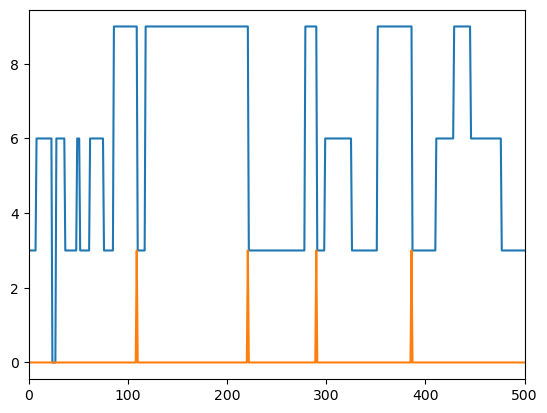

In [366]:
idx = 1
pred_state = get_cleaned_state(ideal_fret[idx, :].numpy() // 2, tau_min=2)
transit = (pred_state[:-1] == high_fret_state) & (pred_state[1:] == low_fret_state)
plt.plot(pred_state)
plt.plot(3 * transit)
plt.xlim([0, 500])

In [418]:
FRET_zero_list = []
FRET_one_list = []
FRET_two_list = []

tau_two = []
tau_one = []
tau_zero = []
FRET_two = []
FRET_zero = []
FRET_one = []

ratio_01 = []
ratio_12 = []
ratio_20 = []

n_transition = np.zeros((3, 3))

for i in range(test_set.size):
    pred_state = ideal_fret[i, :].numpy() // 2
    low_fret_state = np.quantile(pred_state[pred_state>0], 0.05)
    mid_fret_state = np.quantile(pred_state[pred_state>0], 0.5)
    high_fret_state = np.quantile(pred_state[pred_state>0], 0.95)
    tau_zero += evaluation.get_dwell_time(states=pred_state, target_state=low_fret_state)
    tau_one += evaluation.get_dwell_time(states=pred_state, target_state=mid_fret_state)
    tau_two += evaluation.get_dwell_time(states=pred_state, target_state=high_fret_state)
    FRET_zero += get_fret_value(test_set.traces[i], pred_state, target_state=low_fret_state)
    FRET_one += get_fret_value(test_set.traces[i], pred_state, target_state=mid_fret_state)
    FRET_two += get_fret_value(test_set.traces[i], pred_state, target_state=high_fret_state)
    clean_state = get_cleaned_state(pred_state, tau_min=3)
    
    ratio_01.append(np.sum((clean_state[:-1] == low_fret_state) & (clean_state[1:] == mid_fret_state)) / ( np.sum((clean_state[:-1] == low_fret_state) & (clean_state[1:] == mid_fret_state)) + np.sum((clean_state[:-1] == low_fret_state) & (clean_state[1:] == high_fret_state))))
    ratio_12.append(np.sum((clean_state[:-1] == mid_fret_state) & (clean_state[1:] == high_fret_state)) / ( np.sum((clean_state[:-1] == mid_fret_state) & (clean_state[1:] == low_fret_state)) + np.sum((clean_state[:-1] == mid_fret_state) & (clean_state[1:] == high_fret_state))))
    ratio_20.append(np.sum((clean_state[:-1] == high_fret_state) & (clean_state[1:] == low_fret_state)) / ( np.sum((clean_state[:-1] == high_fret_state) & (clean_state[1:] == low_fret_state)) + np.sum((clean_state[:-1] == high_fret_state) & (clean_state[1:] == mid_fret_state))))


bins = np.linspace(0, int(1.2 * np.max(tau_one + tau_zero)), 100)
time_resolution = 1
k_one, k_one_std = evaluation.estimate_k(tau_one, bins=bins, time_resolution=time_resolution, tau_min=2, return_fit_err=True)
k_zero, k_zero_std = evaluation.estimate_k(tau_zero, bins=bins, time_resolution=time_resolution, tau_min=2, return_fit_err=True)
k_two, k_two_std = evaluation.estimate_k(tau_two, bins=bins, time_resolution=time_resolution, tau_min=2, return_fit_err=True)

FRET_zero_list.append(np.mean(reject_outliers(FRET_zero, m=6)))
FRET_one_list.append(np.mean(reject_outliers(FRET_one, m=6)))
FRET_two_list.append(np.mean(reject_outliers(FRET_two, m=6)))

k = np.zeros((3, 3))
k[0, 1] = k_zero * (np.quantile(ratio_01, 0.5))
k[0, 2] = k_zero * (1 - np.quantile(ratio_01, 0.5))
k[1, 0] = k_one * (1 - np.quantile(ratio_12, 0.5))
k[1, 2] = k_one * (np.quantile(ratio_12, 0.5))
k[2, 0] = k_two * (np.quantile(ratio_20, 0.5))
k[2, 1] = k_two * (1 - np.quantile(ratio_20, 0.5))
# print('k_{12} =', k_zero, 'k_{21} =', k_one, '\n', 'FRET_1 =', FRET_zero_list[-1], 'FRET_2 =', FRET_one_list[-1])
print(Fore.MAGENTA, k)
print(Fore.CYAN, transfer_matrix)

 [[0.         0.02767376 0.02396627]
 [0.02070699 0.         0.01826188]
 [0.03918708 0.01567483 0.        ]]
 [[0.    0.03  0.02 ]
 [0.02  0.    0.02 ]
 [0.04  0.015 0.   ]]


In [414]:
np.quantile(ratio, 0.5)

0.7142857142857143

In [408]:
transfer_matrix[2, 0] / np.sum(transfer_matrix[2, :])

0.7272727272727273

In [407]:
n_transition[2, 0] / np.sum(n_transition[2, :])

0.4945945945945946

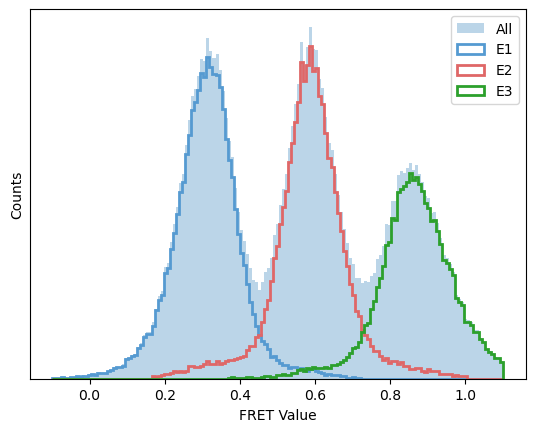

In [368]:
# with plt.style.context(spstyle.get_style('nature-reviews')):
fig, ax = plt.subplots(1, 1)
color = plt.rcParams['axes.prop_cycle'].by_key()['color']
color[0], color[1] = '#559AD1', '#DF6767'
plt.hist(reject_outliers(np.concatenate([FRET_one, FRET_zero, FRET_two]), m=8), bins=np.linspace(-0.1, 1.1, 150), alpha=0.3, edgecolor='none', label='All')

plt.hist(reject_outliers(FRET_zero, m=8), bins=np.linspace(-0.1, 1.1, 150), alpha=1,histtype='step', linewidth=2, label='E1', color=color[0])
# plt.axvline(np.mean(reject_outliers(FRET_zero, m=8)), linewidth=1, linestyle=':')
plt.hist(reject_outliers(FRET_one, m=8), bins=np.linspace(-0.1, 1.1, 150), alpha=1, histtype='step', linewidth=2, label='E2', color=color[1])
# plt.axvline(np.mean(reject_outliers(FRET_one, m=8)), linewidth=1, linestyle=':')
plt.hist(reject_outliers(FRET_two, m=8), bins=np.linspace(-0.1, 1.1, 150), alpha=1, histtype='step', linewidth=2, label='E3', color=color[2])

ax.set_yticks([])
ax.set_ylabel('Counts')
ax.set_xlabel('FRET Value')
ax.legend()
# plt.savefig('figures/fret_hist_2_state.svg', transparent=True)
# plt.savefig('figures/fret_hist_2_state.png', transparent=True)

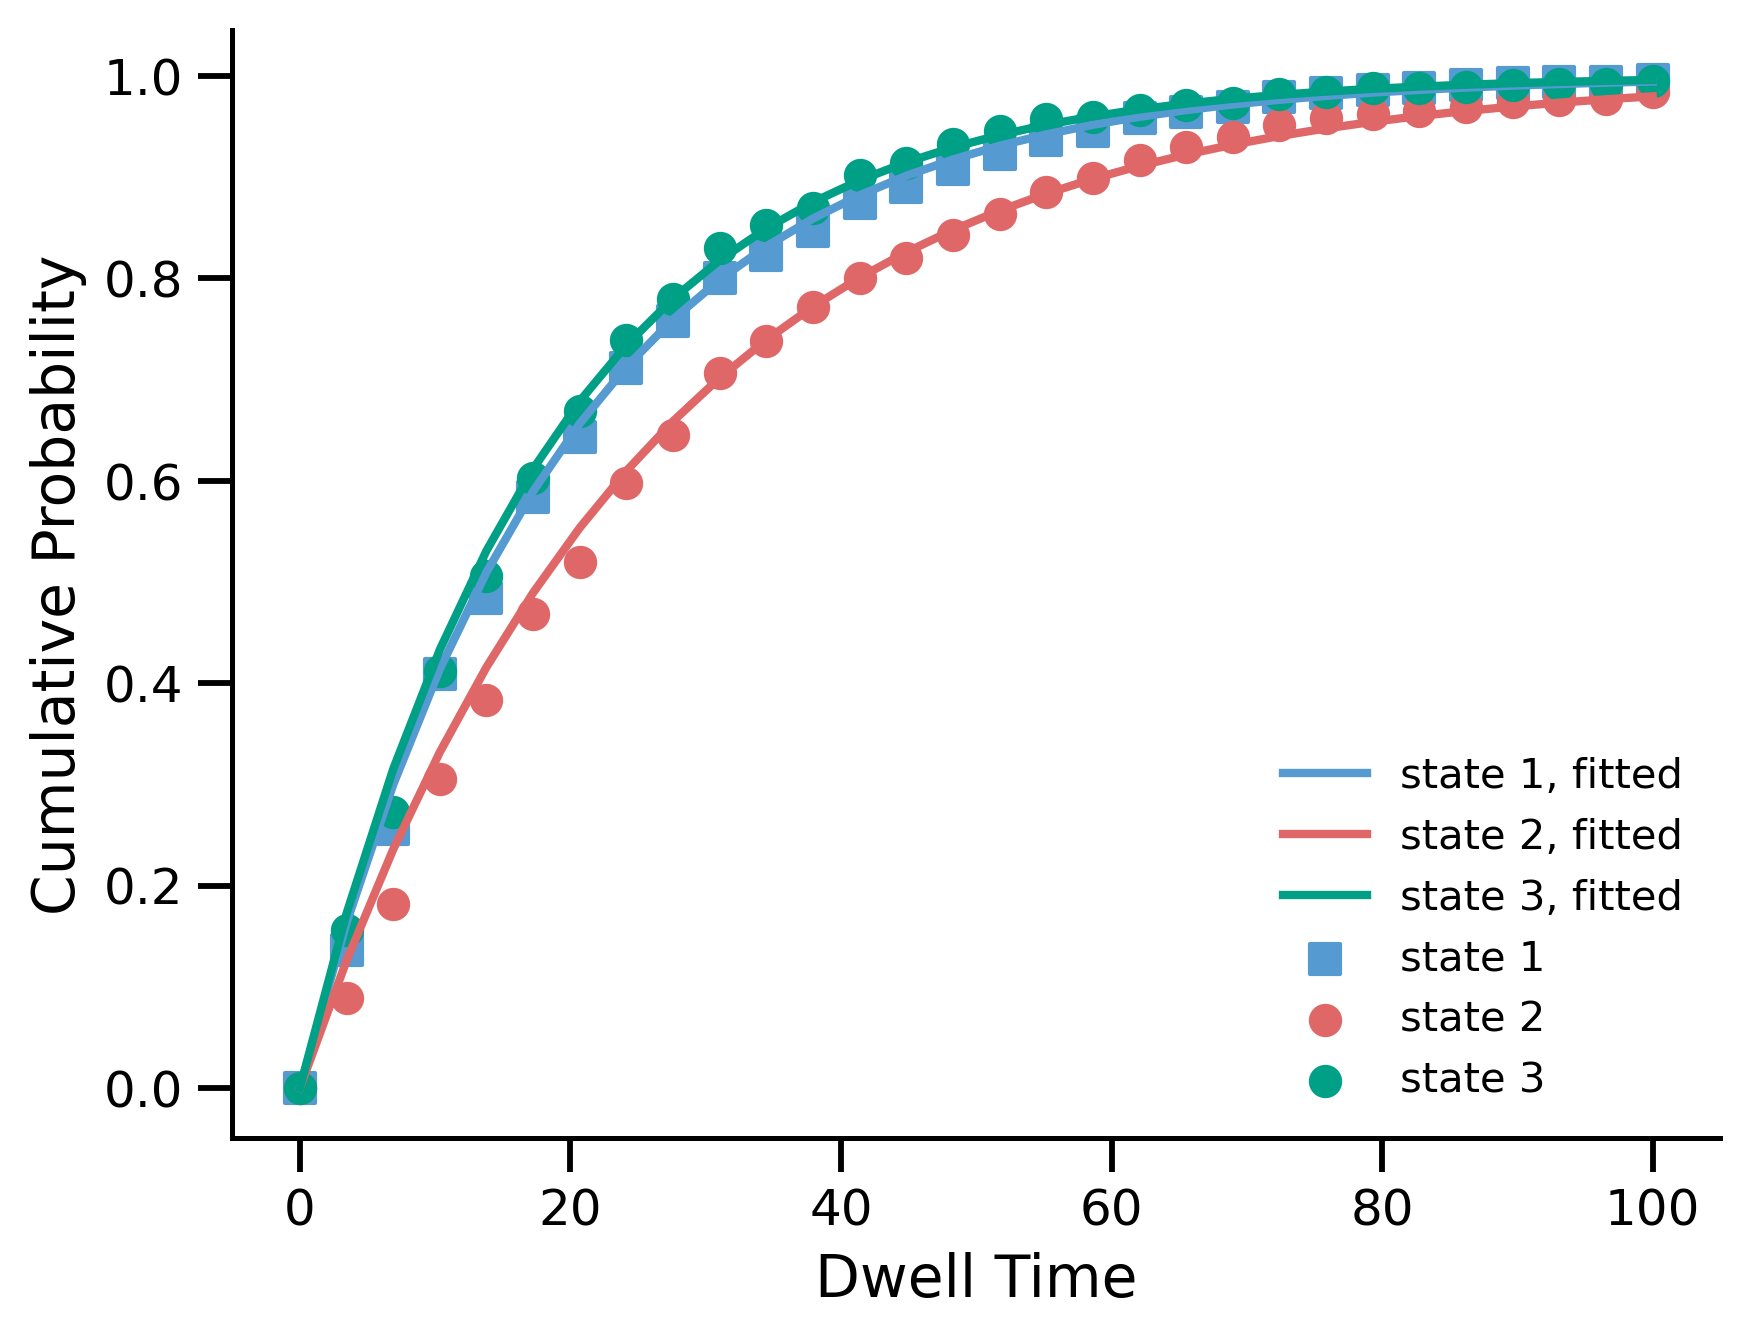

In [369]:
bins = np.linspace(0, 100, 30)
b = 5
with plt.style.context(spstyle.get_style('nature-reviews')):
    # plt.figure(figsize=(8, 6))
    color = plt.rcParams['axes.prop_cycle'].by_key()['color']
    color[0], color[1] = '#559AD1', '#DF6767'
    plt.scatter(bins * time_resolution, evaluation.get_cdf([x - b for x in tau_zero if x > b], bins=bins), color=color[0], marker='s', label='state 1')
    plt.plot(bins * time_resolution, 1 - np.exp(- k_zero * time_resolution * bins), color=color[0], label='state 1, fitted')
    plt.scatter(bins * time_resolution, evaluation.get_cdf([x - b for x in tau_one if x > b], bins=bins), color=color[1], label='state 2')
    plt.plot(bins * time_resolution, 1 - np.exp(- k_one * time_resolution * bins), color=color[1], label='state 2, fitted')
    plt.scatter(bins * time_resolution, evaluation.get_cdf([x - b for x in tau_two if x > b], bins=bins), color=color[2], label='state 3')
    plt.plot(bins * time_resolution, 1 - np.exp(- k_two * time_resolution * bins), color=color[2], label='state 3, fitted')
    plt.xlabel('Dwell Time')
    plt.ylabel('Cumulative Probability')
    plt.legend()
    # plt.savefig('figures/dwell-time-cumulative-prob-fit.svg', transparent=True, dpi=120)

In [ ]:
# open-source dataset

In [296]:
def load_kinsoft_synthetic_trace(path, trace_id, training=True):
    """Loads txt trace files and labels."""
    trace_txt = os.path.join(path, f'trace_{trace_id}.txt')
    label_txt = os.path.join(path, f'state_time_{trace_id}.txt')
    data = np.loadtxt(trace_txt, comments='%')
    
    structured_data = {
        'time': data[:, 0],
        'donor': data[:, 1],
        'acceptor': data[:, 2],
    }
    
    if training:
        label = np.loadtxt(label_txt, comments='%')
        time = data[:, 0]
        state_label = np.zeros_like(time)
        for state, degenerate_state, start, dwell in label:
            state_label[time >= start] = state
        structured_data['label'] = state_label - 1
    else:
        structured_data['label'] = np.zeros_like(data[:, 0])
    
    return structured_data

In [301]:
def kinsoft_trace_to_tensor(trace):
    """Properly converts a kinsoft trace into a tensor."""
    min_unit_length = 100
    trace_set = FRETTraceSet()
    for attr in trace:
        setattr(trace_set, attr, np.expand_dims(trace[attr], axis=0))
    trace_set.time = np.arange(1, trace_set.donor.shape[1] + 1)
    trace_set.size = 1
    trace_set.is_labeled = True
    trace_set.trim(len(trace_set.time) // min_unit_length * min_unit_length)
    return trace_set

In [308]:
len(trace['time'])

311

In [321]:
# 3-state synthetic data
# I think the k calculation has problem
truncate_length_window = 4000
min_length_unit = 50
new_test_sets = []

for i in range(1, 151):
    try:
        trace = load_kinsoft_synthetic_trace('../challenge_data/sim_level2_final_publish/', i, training=False);
    except:
        continue

    truncate_number = (len(trace['time']) - 1) // truncate_length_window + 1
    for j in range(truncate_number):
        trace = load_kinsoft_synthetic_trace('../challenge_data/sim_level2_final_publish/', i, training=False);
        test_set = kinsoft_trace_to_tensor(trace)
        test_set.trim(truncate_length_window, start_frame=(j * truncate_length_window))
        test_set.trim(len(test_set.time) // min_length_unit * min_length_unit)
        new_test_sets.append(test_set)

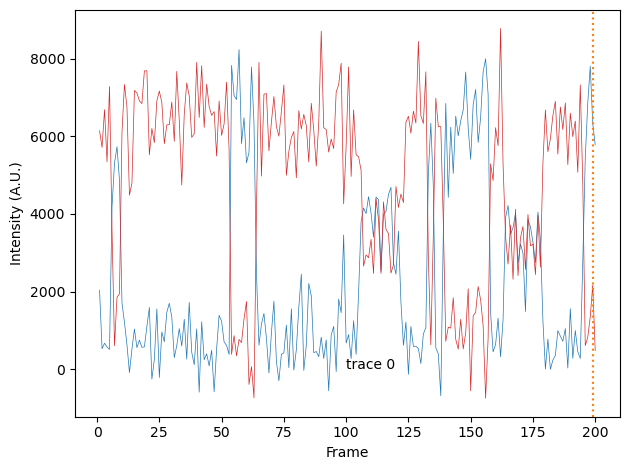

In [322]:
new_test_sets[3].plot_traces(n_start=0, n_traces=1)

In [326]:
high_fret_state

9.0

In [445]:
model = keras.models.load_model(f'saved_models/lstm-model-20240423-203825/FRETSTATE_3STATE.h5', compile=False, custom_objects={'PositionEmbedding': PositionEmbedding})

In [472]:
FRET_zero_list = []
FRET_one_list = []
FRET_two_list = []

tau_two = []
tau_one = []
tau_zero = []
FRET_two = []
FRET_zero = []
FRET_one = []

ratio_01 = []
ratio_12 = []
ratio_20 = []

time_resolution = 1
n_transition = np.zeros((3, 3))

for i in range(len(new_test_sets)):
    ideal_fret_i = tf.cast(tf.argmax(use_posterior(tf.math.softmax(model.predict(new_test_sets[i].to_tensor(), verbose=0), axis=-1)), axis=-1), tf.float32)
    pred_state = ideal_fret_i[0, :].numpy() // 2
    low_fret_state = np.quantile(pred_state[pred_state>0], 0.05)
    mid_fret_state = np.quantile(pred_state[pred_state>0], 0.5)
    high_fret_state = np.quantile(pred_state[pred_state>0], 0.95)
    tau_zero += evaluation.get_dwell_time(states=pred_state, target_state=low_fret_state)
    tau_one += evaluation.get_dwell_time(states=pred_state, target_state=mid_fret_state)
    tau_two += evaluation.get_dwell_time(states=pred_state, target_state=high_fret_state)
    FRET_zero += get_fret_value(new_test_sets[i].traces[0], pred_state, target_state=low_fret_state)
    FRET_one += get_fret_value(new_test_sets[i].traces[0], pred_state, target_state=mid_fret_state)
    FRET_two += get_fret_value(new_test_sets[i].traces[0], pred_state, target_state=high_fret_state)
    clean_state = get_cleaned_state(pred_state, tau_min=2)
    
    ratio_01.append(np.sum((clean_state[:-1] == low_fret_state) & (clean_state[1:] == mid_fret_state)) / ( np.sum((clean_state[:-1] == low_fret_state) & (clean_state[1:] == mid_fret_state)) + np.sum((clean_state[:-1] == low_fret_state) & (clean_state[1:] == high_fret_state))))
    ratio_12.append(np.sum((clean_state[:-1] == mid_fret_state) & (clean_state[1:] == high_fret_state)) / ( np.sum((clean_state[:-1] == mid_fret_state) & (clean_state[1:] == low_fret_state)) + np.sum((clean_state[:-1] == mid_fret_state) & (clean_state[1:] == high_fret_state))))
    ratio_20.append(np.sum((clean_state[:-1] == high_fret_state) & (clean_state[1:] == low_fret_state)) / ( np.sum((clean_state[:-1] == high_fret_state) & (clean_state[1:] == low_fret_state)) + np.sum((clean_state[:-1] == high_fret_state) & (clean_state[1:] == mid_fret_state))))

bins = np.linspace(0, int(1.2 * np.max(tau_one + tau_zero)), 100)
time_resolution = 1
k_one, k_one_std = evaluation.estimate_k(tau_one, bins=bins, time_resolution=time_resolution, tau_min=2, return_fit_err=True)
k_zero, k_zero_std = evaluation.estimate_k(tau_zero, bins=bins, time_resolution=time_resolution, tau_min=2, return_fit_err=True)
k_two, k_two_std = evaluation.estimate_k(tau_two, bins=bins, time_resolution=time_resolution, tau_min=2, return_fit_err=True)

FRET_zero_list.append(np.mean(reject_outliers(FRET_zero, m=2)))
FRET_one_list.append(np.mean(reject_outliers(FRET_one, m=2)))
FRET_two_list.append(np.mean(reject_outliers(FRET_two, m=2)))

k = np.zeros((3, 3))
ratio_01 = np.array(ratio_01)[~np.isnan(ratio_01)]
ratio_12 = np.array(ratio_12)[~np.isnan(ratio_12)]
ratio_20 = np.array(ratio_20)[~np.isnan(ratio_20)]
frame_rate = 10
k[0, 1] = frame_rate * k_zero * (np.quantile(ratio_01, 0.5)) 
k[0, 2] = frame_rate * k_zero * (1 - np.quantile(ratio_01, 0.5))
k[1, 0] = frame_rate * k_one * (1 - np.quantile(ratio_12, 0.5))
k[1, 2] = frame_rate * k_one * (np.quantile(ratio_12, 0.5))
k[2, 0] = frame_rate * k_two * (np.quantile(ratio_20, 0.5))
k[2, 1] = frame_rate * k_two * (1 - np.quantile(ratio_20, 0.5))
# print('k_{12} =', k_zero, 'k_{21} =', k_one, '\n', 'FRET_1 =', FRET_zero_list[-1], 'FRET_2 =', FRET_one_list[-1])
print(Fore.MAGENTA, k)

/var/folders/fq/sqzffsld3xl8qrzw8772z5mh0000gn/T/ipykernel_3719/591748618.py:35: RuntimeWarning: invalid value encountered in long_scalars
  ratio_20.append(np.sum((clean_state[:-1] == high_fret_state) & (clean_state[1:] == low_fret_state)) / ( np.sum((clean_state[:-1] == high_fret_state) & (clean_state[1:] == low_fret_state)) + np.sum((clean_state[:-1] == high_fret_state) & (clean_state[1:] == mid_fret_state))))
/var/folders/fq/sqzffsld3xl8qrzw8772z5mh0000gn/T/ipykernel_3719/591748618.py:33: RuntimeWarning: invalid value encountered in long_scalars
  ratio_01.append(np.sum((clean_state[:-1] == low_fret_state) & (clean_state[1:] == mid_fret_state)) / ( np.sum((clean_state[:-1] == low_fret_state) & (clean_state[1:] == mid_fret_state)) + np.sum((clean_state[:-1] == low_fret_state) & (clean_state[1:] == high_fret_state))))
/var/folders/fq/sqzffsld3xl8qrzw8772z5mh0000gn/T/ipykernel_3719/591748618.py:34: RuntimeWarning: invalid value encountered in long_scalars
  ratio_12.append(np.sum((cle

 [[0.         0.34371157 0.34371157]
 [0.04433937 0.         0.37688468]
 [0.34309012 0.17154506 0.        ]]


In [475]:
print('FRET_1 =', FRET_zero_list[-1], 'FRET_2 =', FRET_one_list[-1], 'FRET_3 =', FRET_two_list[-1])


FRET_1 = 0.11174457695263958 FRET_2 = 0.5531373127814061 FRET_3 = 0.890379302327224


In [465]:
reference_k = np.array([
    [0.0, 0.3, 0.38],
    [0.05, 0, 0.45],
    [0.37, 0.1, 0]
])
print(Fore.CYAN, reference_k)

 [[0.   0.3  0.38]
 [0.05 0.   0.45]
 [0.37 0.1  0.  ]]


In [466]:
delta_G = np.log(k[1, 0] * k[2, 1] * k[0, 2] / k[0, 1] / k[1, 2] / k[2, 0])
print(delta_G)

-2.833213344056216


In [467]:
delta_G = np.log(reference_k[1, 0] * reference_k[2, 1] * reference_k[0, 2] / reference_k[0, 1] / reference_k[1, 2] / reference_k[2, 0])
print(delta_G)

-3.2691686189221674


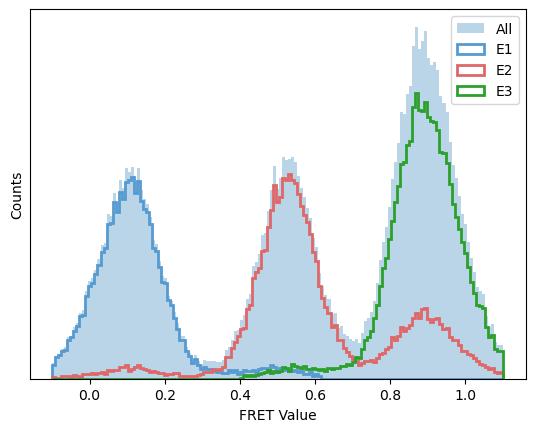

In [474]:
# with plt.style.context(spstyle.get_style('nature-reviews')):
fig, ax = plt.subplots(1, 1)
color = plt.rcParams['axes.prop_cycle'].by_key()['color']
color[0], color[1] = '#559AD1', '#DF6767'
plt.hist(reject_outliers(np.concatenate([FRET_one, FRET_zero, FRET_two]), m=8), bins=np.linspace(-0.1, 1.1, 150), alpha=0.3, edgecolor='none', label='All')

plt.hist(reject_outliers(FRET_zero, m=8), bins=np.linspace(-0.1, 1.1, 150), alpha=1,histtype='step', linewidth=2, label='E1', color=color[0])
# plt.axvline(np.mean(reject_outliers(FRET_zero, m=8)), linewidth=1, linestyle=':')
plt.hist(reject_outliers(FRET_one, m=8), bins=np.linspace(-0.1, 1.1, 150), alpha=1, histtype='step', linewidth=2, label='E2', color=color[1])
# plt.axvline(np.mean(reject_outliers(FRET_one, m=8)), linewidth=1, linestyle=':')
plt.hist(reject_outliers(FRET_two, m=8), bins=np.linspace(-0.1, 1.1, 150), alpha=1, histtype='step', linewidth=2, label='E3', color=color[2])

ax.set_yticks([])
ax.set_ylabel('Counts')
ax.set_xlabel('FRET Value')
ax.legend()
# plt.savefig('figures/fret_hist_2_state.svg', transparent=True)
# plt.savefig('figures/fret_hist_2_state.png', transparent=True)

In [494]:
import smfret.fit as fit

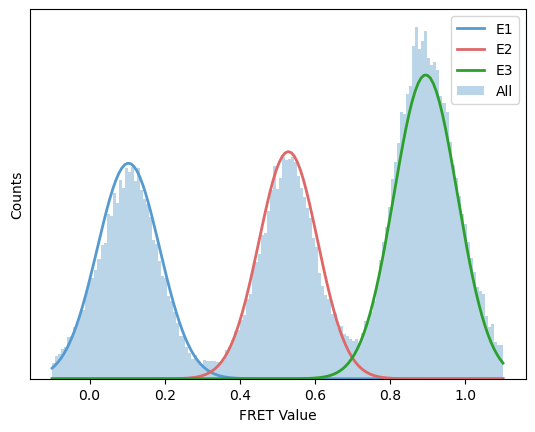

In [514]:
# with plt.style.context(spstyle.get_style('nature-reviews')):
fig, ax = plt.subplots(1, 1)
color = plt.rcParams['axes.prop_cycle'].by_key()['color']
color[0], color[1] = '#559AD1', '#DF6767'
plt.hist(reject_outliers(np.concatenate([FRET_one, FRET_zero, FRET_two]), m=8), bins=np.linspace(-0.1, 1.1, 150), alpha=0.3, edgecolor='none', label='All', density=True)

c0 = fit.gaussian_fit_hist(reject_outliers(FRET_zero, m=4));
c1 = fit.gaussian_fit_hist(reject_outliers(FRET_one, m=2));
c2 = fit.gaussian_fit_hist(reject_outliers(FRET_two, m=4));

n0 = len(reject_outliers(FRET_zero, m=4))
n1 = len(reject_outliers(FRET_one, m=2))
n2 = len(reject_outliers(FRET_two, m=4))

n0, n1, n2 = n0 / (n1 + n2 + n0), n1 / (n1 + n2 + n0), n2 / (n1 + n2 + n0)

plt.plot(np.linspace(-0.1, 1.1, 150), n0 * fit.normpdf(np.linspace(-0.1, 1.1, 150), c0[0], c0[1]), linewidth=2, label='E1', color=color[0])
plt.plot(np.linspace(-0.1, 1.1, 150), n1 * fit.normpdf(np.linspace(-0.1, 1.1, 150), c1[0], c1[1]), linewidth=2, label='E2', color=color[1])
plt.plot(np.linspace(-0.1, 1.1, 150), n2 * fit.normpdf(np.linspace(-0.1, 1.1, 150), c2[0], c2[1]), linewidth=2, label='E3', color=color[2])

# plt.hist(reject_outliers(FRET_zero, m=8), bins=np.linspace(-0.1, 1.1, 150), alpha=1,histtype='step', linewidth=2, label='E1', color=color[0])
# plt.axvline(np.mean(reject_outliers(FRET_zero, m=8)), linewidth=1, linestyle=':')
# plt.hist(reject_outliers(FRET_one, m=8), bins=np.linspace(-0.1, 1.1, 150), alpha=1, histtype='step', linewidth=2, label='E2', color=color[1])
# plt.axvline(np.mean(reject_outliers(FRET_one, m=8)), linewidth=1, linestyle=':')
# plt.hist(reject_outliers(FRET_two, m=8), bins=np.linspace(-0.1, 1.1, 150), alpha=1, histtype='step', linewidth=2, label='E3', color=color[2])

ax.set_yticks([])
ax.set_ylabel('Counts')
ax.set_xlabel('FRET Value')
ax.legend()
plt.savefig('figures/fret_hist_3_state.svg', transparent=True)
# plt.savefig('figures/fret_hist_2_state.png', transparent=True)

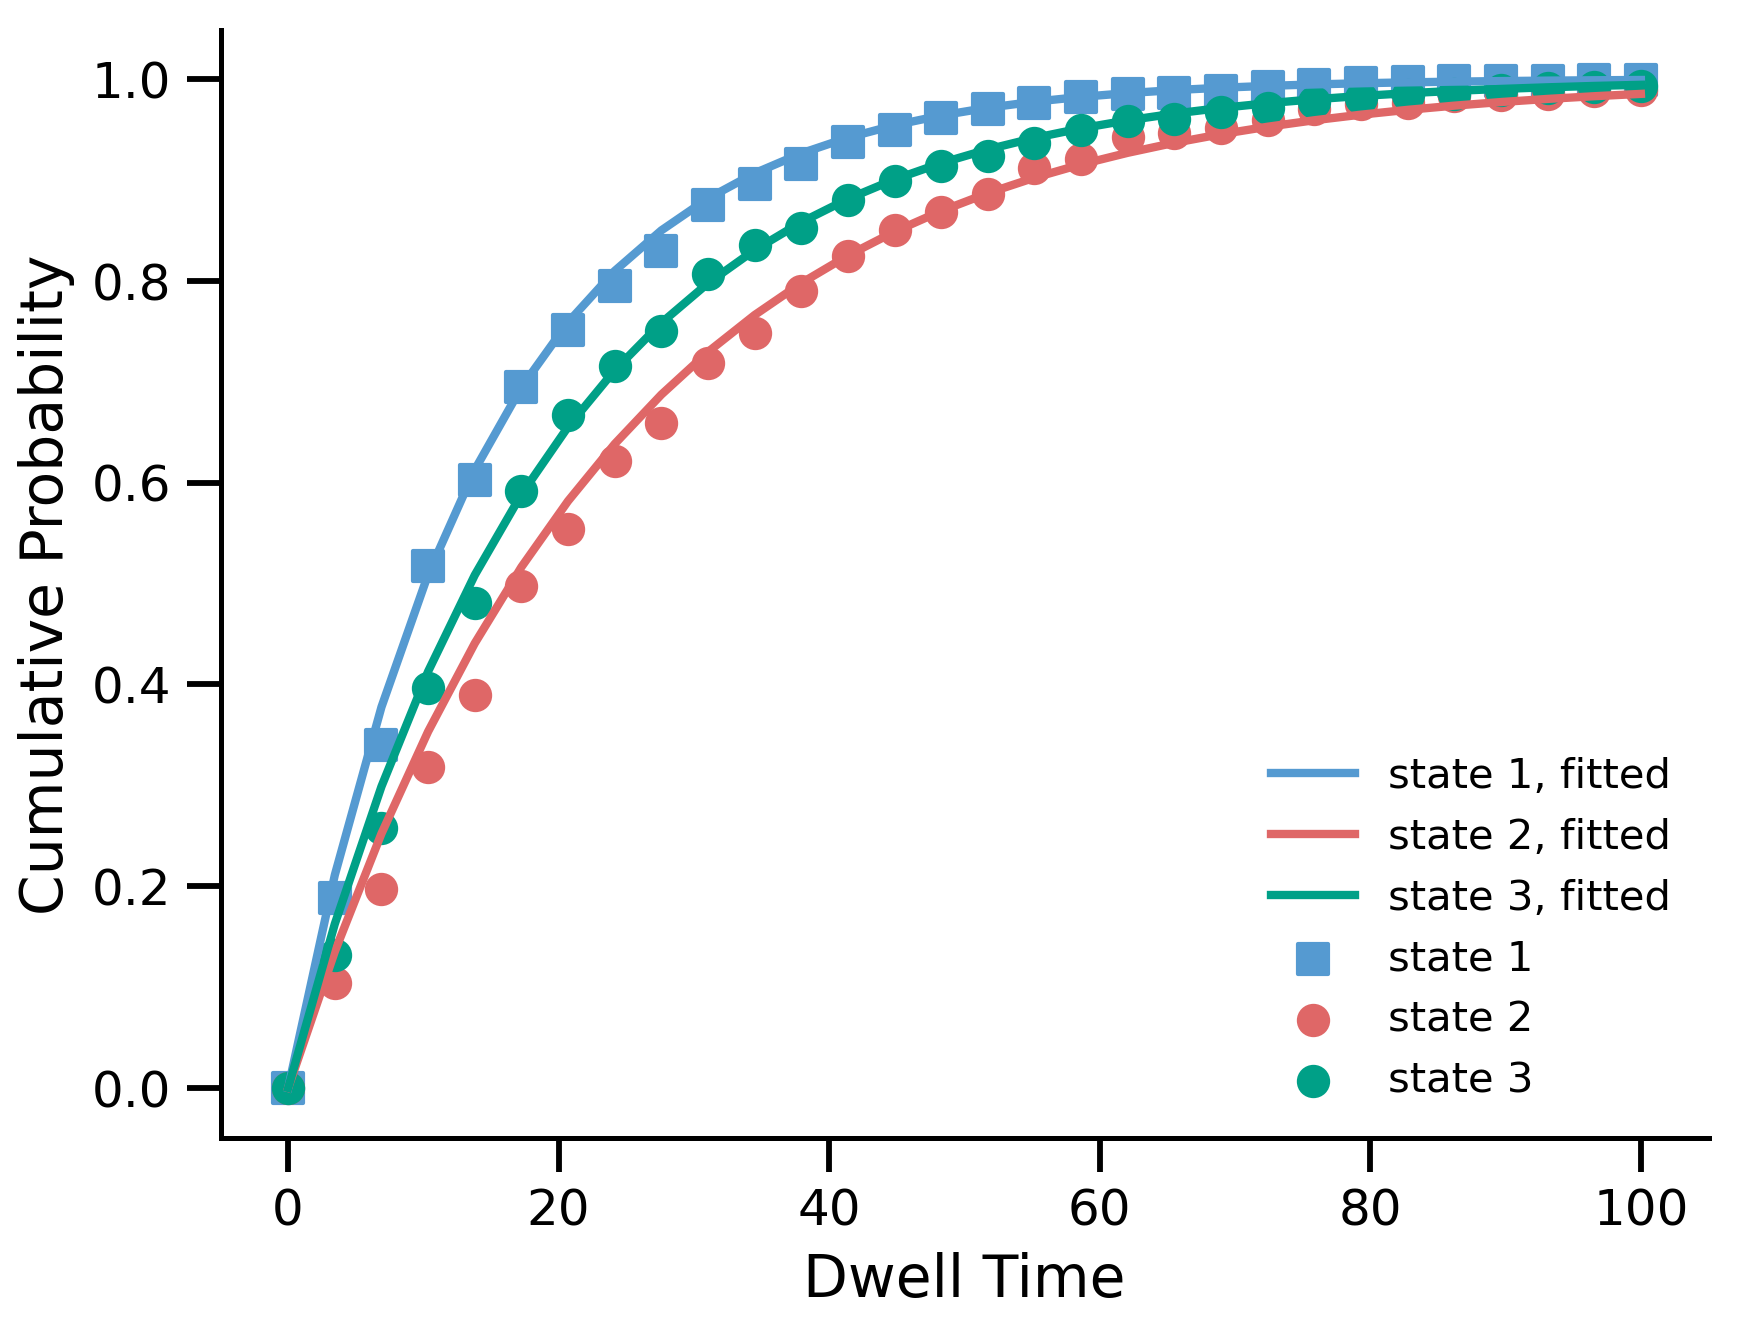

In [515]:
bins = np.linspace(0, 100, 30)
b = 5
with plt.style.context(spstyle.get_style('nature-reviews')):
    # plt.figure(figsize=(8, 6))
    color = plt.rcParams['axes.prop_cycle'].by_key()['color']
    color[0], color[1] = '#559AD1', '#DF6767'
    plt.scatter(bins * time_resolution, evaluation.get_cdf([x - b for x in tau_zero if x > b], bins=bins), color=color[0], marker='s', label='state 1')
    plt.plot(bins * time_resolution, 1 - np.exp(- k_zero * time_resolution * bins), color=color[0], label='state 1, fitted')
    plt.scatter(bins * time_resolution, evaluation.get_cdf([x - b for x in tau_one if x > b], bins=bins), color=color[1], label='state 2')
    plt.plot(bins * time_resolution, 1 - np.exp(- k_one * time_resolution * bins), color=color[1], label='state 2, fitted')
    plt.scatter(bins * time_resolution, evaluation.get_cdf([x - b for x in tau_two if x > b], bins=bins), color=color[2], label='state 3')
    plt.plot(bins * time_resolution, 1 - np.exp(- k_two * time_resolution * bins), color=color[2], label='state 3, fitted')
    plt.xlabel('Dwell Time')
    plt.ylabel('Cumulative Probability')
    plt.legend()
    plt.savefig('figures/dwell-time-cumulative-prob-fit-3-state.svg', transparent=True, dpi=120)